# Model Exploration

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 07/04/2025   | Martin | Create  | Notebook created for model exploration. Completed baseline model - Score: 13.29 | 
| 09/04/2025   | Martin | Update  | Completed XGBoost + PCA - Score: 14.55 | 
| 17/04/2025   | Martin | Update  | Completed TruncSVD + LGBM - Score: 13.51 | 

# Content

* [Data Preparation](#data-preparation)
* [XGBoost Vanilla](#xgboost-vanilla)
* [PCA + XGBoost](#pca--xgboost)

# Data Preparation

Prepare the training and testing data for model building

In [1]:
import numpy as np
import polars as pl

from utils.util import clean_data
from sklearn.model_selection import train_test_split

In [2]:
# Load all datasets
train = pl.read_csv('data/train.csv')
test = pl.read_csv('data/test.csv')
additional = pl.read_csv('data/podcast_dataset.csv')

In [4]:
train.head()

id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
i64,str,str,f64,str,f64,str,str,f64,f64,str,f64
0,"""Mystery Matters""","""Episode 98""",null,"""True Crime""",74.81,"""Thursday""","""Night""",null,0.0,"""Positive""",31.41998
1,"""Joke Junction""","""Episode 26""",119.8,"""Comedy""",66.95,"""Saturday""","""Afternoon""",75.95,2.0,"""Negative""",88.01241
2,"""Study Sessions""","""Episode 16""",73.9,"""Education""",69.97,"""Tuesday""","""Evening""",8.97,0.0,"""Negative""",44.92531
3,"""Digital Digest""","""Episode 45""",67.17,"""Technology""",57.22,"""Monday""","""Morning""",78.7,2.0,"""Positive""",46.27824
4,"""Mind & Body""","""Episode 86""",110.51,"""Health""",80.07,"""Monday""","""Afternoon""",58.68,3.0,"""Neutral""",75.61031


In [5]:
test.head()

id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
i64,str,str,f64,str,f64,str,str,f64,f64,str
750000,"""Educational Nuggets""","""Episode 73""",78.96,"""Education""",38.11,"""Saturday""","""Evening""",53.33,1.0,"""Neutral"""
750001,"""Sound Waves""","""Episode 23""",27.87,"""Music""",71.29,"""Sunday""","""Morning""",null,0.0,"""Neutral"""
750002,"""Joke Junction""","""Episode 11""",69.1,"""Comedy""",67.89,"""Friday""","""Evening""",97.51,0.0,"""Positive"""
750003,"""Comedy Corner""","""Episode 73""",115.39,"""Comedy""",23.4,"""Sunday""","""Morning""",51.75,2.0,"""Positive"""
750004,"""Life Lessons""","""Episode 50""",72.32,"""Lifestyle""",58.1,"""Wednesday""","""Morning""",11.3,2.0,"""Neutral"""


In [6]:
train.columns

['id',
 'Podcast_Name',
 'Episode_Title',
 'Episode_Length_minutes',
 'Genre',
 'Host_Popularity_percentage',
 'Publication_Day',
 'Publication_Time',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Episode_Sentiment',
 'Listening_Time_minutes']

In [7]:
additional.columns

['Podcast_Name',
 'Episode_Title',
 'Episode_Length_minutes',
 'Genre',
 'Host_Popularity_percentage',
 'Publication_Day',
 'Publication_Time',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Episode_Sentiment',
 'Listening_Time_minutes']

In [30]:
additional = additional.insert_column(
  0,
  pl.Series('id', list(range(train['id'][-1]+1, train['id'][-1]+1+additional.shape[0])))
)
additional = additional.with_columns(
  pl.col('Number_of_Ads').cast(pl.Float64)
)
# Fill Nulls
additional = additional.fill_null(strategy='mean')
additional.head()

id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
i64,str,str,f64,str,f64,str,str,f64,f64,str,f64
750000,"""Healthy Living""","""Episode 77""",99.25,"""Health""",21.37,"""Thursday""","""Night""",70.22,3.0,"""Positive""",55.158695
750001,"""Mystery Matters""","""Episode 6""",19.43,"""True Crime""",47.19,"""Friday""","""Evening""",75.15,1.0,"""Neutral""",7.686559
750002,"""Current Affairs""","""Episode 1""",117.03,"""News""",96.33,"""Sunday""","""Night""",57.95,3.0,"""Neutral""",110.064645
750003,"""Mystery Matters""","""Episode 38""",16.97,"""True Crime""",25.73,"""Monday""","""Night""",24.19,0.0,"""Positive""",12.00038
750004,"""Humor Hub""","""Episode 73""",83.48,"""Comedy""",76.69,"""Tuesday""","""Afternoon""",42.31,3.0,"""Positive""",45.560293


In [7]:
SEED = 42

In [32]:
# Optional to add additional data
train = pl.concat([train, additional], how='vertical')

In [3]:
cl_train = clean_data(train)
cl_test = clean_data(test)

# Remove ids
cl_train = cl_train.drop('id')
test_id = cl_test['id']
cl_test = cl_test.drop('id')

We will have 2 versions of the data - one where the target variable is separated from the features using sklearn's `train_test_split` and another where the dataframe remains intact but is randomly sampled

* train - 80%
* validation - 20%
* test - submission to Kaggle

In [8]:
# sklearns train test_split
y = cl_train['listening_time_minutes']
X = cl_train.drop('listening_time_minutes')
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [9]:
# Standard split
temp = cl_train.sample(fraction=1, shuffle=True, seed=SEED)
test_size = int(0.2 * temp.shape[0])
cl_valid_samp, cl_train_samp = temp.head(test_size), temp.tail(-test_size)

---

# XGBoost Vanilla

This model will serve as a baseline. XGBoost is a gradient boosting algorithm that has shown to provide good performance across many different tasks. Here we are using it as a regressor

In [6]:
import xgboost as xgb
import wandb

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

wandb.login()

In [15]:
def wandb_track(
  config: dict,
  y_test: np.array,
  y_pred: np.array,
  train_error: np.array,
  test_error: np.array,
  tags: list = [],
  notes: str = ""
) -> None:
  run = wandb.init(
    project="podcast-listening-time",
    notes=notes,
    tags=tags,
    config={
      'dataset': "Podcast-listening-time-kaggle"
    }
  )

  # Plot general metrics
  metrics = {
    'mae': mean_absolute_error(y_test, y_pred),
    'mse': mean_squared_error(y_test, y_pred),
    'rmse': root_mean_squared_error(y_test, y_pred),
    'r2': r2_score(y_test, y_pred),
  }
  run.log({
    **metrics
  })

  # Plot Training and Evaluation rmse
  data = [[x, y] for x, y in zip(range(len(train_error)), train_error)]
  table = wandb.Table(data=data, columns=['round', 'rmse'])
  run.log({
    'train_error': wandb.plot.line(
      table, 'round', 'rmse', title="Training Error"
    )
  })

  data = [[x, y] for x, y in zip(range(len(test_error)), test_error)]
  table = wandb.Table(data=data, columns=['round', 'rmse'])
  run.log({
    'test_error': wandb.plot.line(
      table, 'round', 'rmse', title="Testing Error"
    )
  })

  # Update config with run details
  run.config.update(config)

  # Finish run
  run.finish()


In [10]:
NUM_ROUNDS = 50
params = {
  'device': 'cuda',
  'objective': 'reg:squarederror',
  'max_depth': 8,
  'learning_rate': 0.3,
  'eval_metric': 'rmse',
}
results = {}

# Declare DMatrix data format
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Define evaluation data format
evallist = [(dtrain, 'train'), (dvalid, 'eval')]

In [11]:
best_model = xgb.train(
  params=params,
  dtrain=dtrain,
  num_boost_round=NUM_ROUNDS,
  evals=evallist,
  evals_result=results
)

[0]	train-rmse:21.21406	eval-rmse:21.19730
[1]	train-rmse:17.58723	eval-rmse:17.56956
[2]	train-rmse:15.49432	eval-rmse:15.47977
[3]	train-rmse:14.34746	eval-rmse:14.33688
[4]	train-rmse:13.74140	eval-rmse:13.73807
[5]	train-rmse:13.42417	eval-rmse:13.42652
[6]	train-rmse:13.25729	eval-rmse:13.26685
[7]	train-rmse:13.16617	eval-rmse:13.18553
[8]	train-rmse:13.11222	eval-rmse:13.14045
[9]	train-rmse:13.07957	eval-rmse:13.11648
[10]	train-rmse:13.05481	eval-rmse:13.10065
[11]	train-rmse:13.03365	eval-rmse:13.08846
[12]	train-rmse:13.01960	eval-rmse:13.08372
[13]	train-rmse:13.00783	eval-rmse:13.08087
[14]	train-rmse:12.98774	eval-rmse:13.07489
[15]	train-rmse:12.96970	eval-rmse:13.06773
[16]	train-rmse:12.95725	eval-rmse:13.06609
[17]	train-rmse:12.94711	eval-rmse:13.06235
[18]	train-rmse:12.93253	eval-rmse:13.06046
[19]	train-rmse:12.92361	eval-rmse:13.05923
[20]	train-rmse:12.91100	eval-rmse:13.05661
[21]	train-rmse:12.89930	eval-rmse:13.05441
[22]	train-rmse:12.88905	eval-rmse:13.0539

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

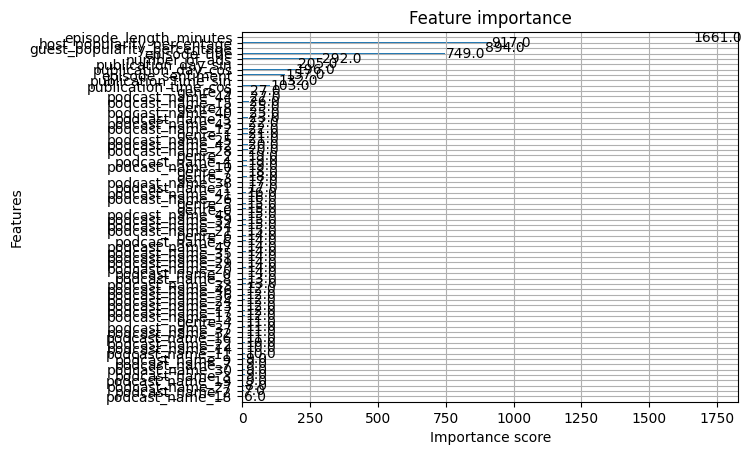

In [35]:
xgb.plot_importance(best_model)

<Axes: >

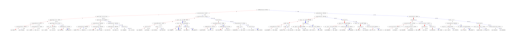

In [38]:
xgb.plot_tree(best_model)

In [36]:
# Get metrics to submit to wandb
train_errors = np.array(results['train']['rmse'])
eval_errors = np.array(results['eval']['rmse'])
y_pred = best_model.predict(dvalid)

tags = ['baseline', 'xgboost']
notes = 'Baseline XGBoost model'

wandb_track(
  config=params,
  y_test=y_valid,
  y_pred=y_pred,
  train_error=train_errors,
  test_error=eval_errors,
  tags=tags,
  notes=notes
)

mae,▁
mse,▁
r2,▁
rmse,▁
mae,9.45814
mse,169.52855
r2,0.76961
rmse,13.02031


---

# PCA + XGBoost

Dimensionality reduction together with normalising the data will hopefully help to improve performance

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [120]:
N_COMPONENTS = 50

# # Data transformation
# train_f = cl_train.select(
#   pl.col(pl.Float64)
# )
# test_f = cl_test.select(
#   pl.col(pl.Float64)
# )

# # Temporarily remove target variable from training data
# train_f = train_f.drop('listening_time_minutes')

# If applied to the whole dataframe
target = cl_train['listening_time_minutes']
train_f = cl_train.drop('listening_time_minutes')
test_f = cl_test.clone()

# Apply the standard scaler and 
ss = StandardScaler()
train_data = ss.fit_transform(train_f)
test_data = ss.transform(test_f)
train_data[np.isnan(train_data)] = 0

# Apply PCA
pca = PCA(n_components=N_COMPONENTS)
train_data = pca.fit_transform(train_data)
test_data = pca.transform(test_data)

# Form the data
pca_train = pl.DataFrame(train_data, schema=[f"pca_{i}" for i in range(N_COMPONENTS)])
pca_test = pl.DataFrame(test_data, schema=[f"pca_{i}" for i in range(N_COMPONENTS)])

# # Remove original columns from data
# cl_train_pca = cl_train.drop(train_f.columns)
# cl_test_pca = cl_test.drop(test_f.columns)

# # Add new pca columns to data
# cl_train_pca = cl_train_pca.with_columns(
#   pca_train
# )
# cl_test_pca = cl_test_pca.with_columns(
#   pca_test
# )

# Final data
cl_train_pca = pca_train.with_columns(
  target
)
cl_test_pca = pca_test.clone()

In [114]:
cl_test_pca.head()

pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.020317,-0.060113,-0.096405,0.022361,0.065569,0.400473,0.476095,0.253239,5.389244,-1.050787,0.717597,-0.155515,-0.137908,0.221832,0.093045,0.402399,-0.198112,0.51599,0.092602,-0.221064
-0.011658,-0.133649,-0.243119,0.099886,0.038323,0.908269,3.900954,-2.521522,-0.644667,1.889857,0.876766,-0.384081,0.584187,-1.363221,-0.459729,-0.112049,0.47702,-0.029423,0.178245,0.337555
0.047205,-0.41173,-0.57993,3.854711,-1.222662,-0.904841,-0.568245,-0.217399,-0.293321,-0.825245,-0.990588,0.7378,0.553827,-0.64416,-1.50063,0.185497,0.299629,0.001685,-0.044058,-0.375554
0.014197,-0.356893,-0.659278,3.776609,-1.169327,-0.82944,-0.613624,-0.228725,-0.243943,1.66834,1.611799,0.288032,0.374017,0.447868,0.075074,0.02138,0.24865,-1.342239,-0.352019,-0.296625
-0.473286,-1.02343,-2.239133,-2.074947,-2.28037,-0.902678,-0.589703,-0.153312,-0.202259,1.862762,-0.728404,-0.024635,-0.713072,0.565557,-1.248746,-0.78696,0.864802,0.508115,-0.734813,-0.057112


In [121]:
# Split data
y = cl_train_pca['listening_time_minutes']
X = cl_train_pca.drop('listening_time_minutes')
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [127]:
NUM_ROUNDS = 100
params = {
  'device': 'cuda',
  'objective': 'reg:squarederror',
  'max_depth': 10,
  'learning_rate': 0.2,
  'eval_metric': 'rmse',
}
results = {}

# Declare DMatrix data format
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Define evaluation data format
evallist = [(dtrain, 'train'), (dvalid, 'eval')]

# Train model
pca_model = xgb.train(
  params=params,
  dtrain=dtrain,
  num_boost_round=NUM_ROUNDS,
  evals=evallist,
  evals_result=results
)

[0]	train-rmse:24.04640	eval-rmse:24.06718
[1]	train-rmse:21.73005	eval-rmse:21.79464
[2]	train-rmse:19.95059	eval-rmse:20.06186
[3]	train-rmse:18.57235	eval-rmse:18.72894
[4]	train-rmse:17.49641	eval-rmse:17.69962
[5]	train-rmse:16.68082	eval-rmse:16.93316
[6]	train-rmse:16.07109	eval-rmse:16.36436
[7]	train-rmse:15.60212	eval-rmse:15.93674
[8]	train-rmse:15.21024	eval-rmse:15.58441
[9]	train-rmse:14.85515	eval-rmse:15.26907
[10]	train-rmse:14.60560	eval-rmse:15.05742
[11]	train-rmse:14.37719	eval-rmse:14.86229
[12]	train-rmse:14.21063	eval-rmse:14.72739
[13]	train-rmse:14.03358	eval-rmse:14.58198
[14]	train-rmse:13.90016	eval-rmse:14.47189
[15]	train-rmse:13.75966	eval-rmse:14.36334
[16]	train-rmse:13.64610	eval-rmse:14.27874
[17]	train-rmse:13.55188	eval-rmse:14.21002
[18]	train-rmse:13.45164	eval-rmse:14.12997
[19]	train-rmse:13.37366	eval-rmse:14.07798
[20]	train-rmse:13.27838	eval-rmse:14.01235
[21]	train-rmse:13.21264	eval-rmse:13.97046
[22]	train-rmse:13.15307	eval-rmse:13.9304

In [131]:
# Get metrics to submit to wandb
train_errors = np.array(results['train']['rmse'])
eval_errors = np.array(results['eval']['rmse'])
y_pred = pca_model.predict(dvalid)

tags = ['pca', 'xgboost']
notes = 'XGBoost + PCA model'

wandb_track(
  config=params,
  y_test=y_valid,
  y_pred=y_pred,
  train_error=train_errors,
  test_error=eval_errors,
  tags=tags,
  notes=notes
)

mae,▁
mse,▁
r2,▁
rmse,▁
mae,10.07028
mse,186.0379
r2,0.74717
rmse,13.63957


In [123]:
# Make prediction on test set
dtest = xgb.DMatrix(cl_test_pca)

preds = pca_model.predict(dtest)

results = pl.DataFrame({
  'id': test_id,
  'Listening_Time_minutes': preds
})

In [124]:
results.write_csv('results/xgb_pca.csv')

---

# TruncatedSVD + LightGBM

`TruncatedSVD` performs better on sparse matrices, and `LightGBM` is an alternative gradient boosting method that has similar performance to XGBoost

target: `listening_time_minutes`

In [43]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor, log_evaluation

In [18]:
# Split into sparse and without sparse
def transform_svd(train, test=None):
  X_train_wo_oh = train.select(
    pl.col(pl.Float64),
    pl.col(pl.Int64)
  )
  X_train_oh = train.select(
    pl.col(pl.UInt8)
  )

  # Apply standardisation
  ss = StandardScaler()
  ss_trans = ss.fit_transform(X_train_wo_oh)
  X_train_wo_oh = pl.DataFrame(ss_trans, schema=X_train_wo_oh.columns)

  # Optional: Join back to original data
  X_train_lgb = pl.concat([X_train_wo_oh, X_train_oh], how='horizontal')

  # Fill NaN values
  X_train_lgb = X_train_lgb.with_columns(
    pl.col('number_of_ads').fill_nan(0)
  )

  # Apply the Truncated SVD
  perc_cols = 0.3
  num_cols = int(X_train_lgb.shape[1] * perc_cols)

  svd = TruncatedSVD(n_components=num_cols, random_state=SEED)
  X_train_svd = svd.fit_transform(X_train_lgb)

  if test is not None:
    test_wo_oh = test.select(
      pl.col(pl.Float64),
      pl.col(pl.Int64)
    )
    test_oh = test.select(
      pl.col(pl.UInt8)
    )

    test_trans = ss.transform(test_wo_oh)
    test_wo_oh = pl.DataFrame(test_trans, schema=test_wo_oh.columns)

    # Optional: Join back to original data
    test_lgb = pl.concat([test_wo_oh, test_oh], how='horizontal')

    # Fill NaN values
    test_lgb = test_lgb.with_columns(
      pl.col('number_of_ads').fill_nan(0)
    )

    # Apply the Truncated SVD
    test_svd = svd.transform(test_lgb)

    return X_train_svd, test_svd

  return X_train_svd

In [74]:
# Apply transformations to validation data
cl_train_y = cl_train_samp['listening_time_minutes']
cl_train_X = cl_train_samp.drop('listening_time_minutes')
cl_valid_y = cl_valid_samp['listening_time_minutes']
cl_valid_X = cl_valid_samp.drop('listening_time_minutes')

# cl_train_X, cl_valid_X = transform_svd(cl_train_X, cl_valid_X)

In [63]:
# Train LGBM
params = {
  'n_iter': 1000, 
  'max_depth': -1,
  'num_leaves': 1024,
  'colsample_bytree': 0.7,
  'learning_rate': 0.03,
  'objective': 'l2',
  'metric': 'rmse',
  'verbosity': -1,
  'max_bin': 1024
}

lgbm = LGBMRegressor(**params)
lgbm.fit(
  cl_train_X, cl_train_y,
  # eval_set=list(zip(cl_valid_X, cl_valid_y.to_numpy())),
  callbacks=[log_evaluation(100)]
)

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.03, max_bin=1024,
              metric='rmse', n_iter=1000, num_leaves=1024, objective='l2',
              verbosity=-1)

In [67]:
# Make predictions
y_pred = lgbm.predict(cl_valid_X)

# Scoring
print(f"The R2 Score: {r2_score(cl_valid_y, y_pred)}")
print(f"The RMSE: {root_mean_squared_error(cl_valid_y, y_pred)}")

/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


The R2 Score: 0.7588059799264902
The RMSE: 13.270010551342624


Retrain on full data

In [78]:
train_y = cl_train['listening_time_minutes']
train_X = cl_train.drop('listening_time_minutes')

train_X, test = transform_svd(train_X, cl_test)

In [81]:

# Train LGBM
params = {
  'n_iter': 1000, 
  'max_depth': -1,
  'num_leaves': 1024,
  'colsample_bytree': 0.7,
  'learning_rate': 0.03,
  'objective': 'l2',
  'metric': 'rmse',
  'verbosity': -1,
  'max_bin': 1024
}

lgbm = LGBMRegressor(**params)
lgbm.fit(
  train_X, train_y,
  # eval_set=list(zip(cl_valid_X, cl_valid_y.to_numpy())),
  callbacks=[log_evaluation(100)]
)

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.03, max_bin=1024,
              metric='rmse', n_iter=1000, num_leaves=1024, objective='l2',
              verbosity=-1)

In [82]:
# Make predictions
y_pred = lgbm.predict(test)

# Export
pl.DataFrame({
  'id': test_id,
  'listening_time_minutes': y_pred
}).write_csv('results/truncsvd_lgbm.csv')

/mnt/d/Software/venv/py310_ubun/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


---

In [2]:
import pandas as pd
import xgboost as xgb

In [6]:
NUM_ROUNDS = 20
def data_iterator(filepath, batch_size=10_000):
  for chunk in pd.read_csv(filepath, chunksize=batch_size):
    y = chunk['Listening_Time_minutes']
    X = chunk.drop('Listening_Time_minutes', axis=1)
    dmat = xgb.DMatrix(X, label=y)
    yield dmat

train_iter = data_iterator('./data/train_le.csv')

In [7]:
model = None
params = {
  'device': 'gpu',
  'objective': 'reg:squarederror',
  # 'tree_method': 'hist',
  # 'max_depth': 14,
  # 'colsample_bytree': 0.5,
  # 'subsample': 0.9,
  # 'learning_rate': 0.2,
}

for i, dmat in enumerate(train_iter):
  print(dmat)
  if model is None:
    model = xgb.train(
      params,
      dmat,
      num_boost_round=1,
    )
  else:
    model.update(dmat, iteration=0)

d:\Downloads\py13_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:59:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
d:\Downloads\py13_venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:59:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


In [3]:
test = pd.read_csv('./data/test_le.csv')

In [5]:
test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,...,Podcast_Name_Host_Popularity_percentage_Publication_Day_Publication_Time_Episode_Sentiment,Podcast_Name_Host_Popularity_percentage_Publication_Day_Guest_Popularity_percentage_Episode_Sentiment,Podcast_Name_Host_Popularity_percentage_Publication_Time_Guest_Popularity_percentage_Episode_Sentiment,Podcast_Name_Publication_Day_Publication_Time_Guest_Popularity_percentage_Episode_Sentiment,Episode_Length_minutes_Host_Popularity_percentage_Publication_Day_Publication_Time_Guest_Popularity_percentage,Episode_Length_minutes_Host_Popularity_percentage_Publication_Day_Publication_Time_Episode_Sentiment,Episode_Length_minutes_Host_Popularity_percentage_Publication_Day_Guest_Popularity_percentage_Episode_Sentiment,Episode_Length_minutes_Host_Popularity_percentage_Publication_Time_Guest_Popularity_percentage_Episode_Sentiment,Episode_Length_minutes_Publication_Day_Publication_Time_Guest_Popularity_percentage_Episode_Sentiment,Host_Popularity_percentage_Publication_Day_Publication_Time_Guest_Popularity_percentage_Episode_Sentiment
0,750000,11,73,78.96,2,38.11,2,1,53.33,1.0,...,58426,59291,59202,48397,205226,202886,205123,204763,194924,56844
1,750001,36,23,27.87,5,71.29,3,2,52.19,0.0,...,182127,184707,184440,149914,71565,71044,71556,71511,70646,158505
2,750002,24,11,69.10,1,67.89,0,1,97.51,0.0,...,126230,128072,127873,102004,186775,184541,186677,186327,176674,147709
3,750003,4,73,115.39,1,23.40,3,2,51.75,2.0,...,21505,21807,21773,19567,34303,34077,34304,34272,33888,8485
4,750004,27,50,72.32,4,58.10,6,2,11.30,2.0,...,139366,141372,141147,116805,194272,191987,194167,193816,184115,116299


In [8]:
ids = test['id']
X_test = test.drop('id', axis=1)

In [9]:
dtest = xgb.DMatrix(X_test)

In [10]:
preds = model.predict(dtest)

In [11]:
res = pd.DataFrame(
  {
    'id': ids,
    'Listening_Time_minutes' : preds
  }
)
res.head()

,id,Listening_Time_minutes
0,750000,70.844452
1,750001,29.654222
2,750002,36.827530
3,750003,93.394165
4,750004,47.476665


In [40]:
res.to_csv('./results/xgb_perm.csv', index=False)